In [58]:
#from IPython.display import display

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 15)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# Catfish Sales Data

In [59]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [60]:
#read data
catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)

In [61]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

### Introduce an Anomaly

In [62]:
import datetime
idx = pd.IndexSlice

In [63]:
catfish_sales.loc["1998-12-1"]['Total'] = 10000

In [64]:
catfish_sales

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


In [65]:
start_date = datetime.datetime(1996,1,1)
end_date = datetime.datetime(2000,1,1)

In [66]:
start_date

datetime.datetime(1996, 1, 1, 0, 0)

In [67]:

lim_catfish_sales = catfish_sales[start_date:end_date]

In [68]:
lim_catfish_sales

,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
1996-06-01,18074
1996-07-01,18719
1996-08-01,20217
1996-09-01,19642


In [69]:
#At December 1 1998
lim_catfish_sales.iloc[0]

Total    20322
Name: 1996-01-01 00:00:00, dtype: int64

In [70]:
lim_catfish_sales

,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
1996-06-01,18074
1996-07-01,18719
1996-08-01,20217
1996-09-01,19642


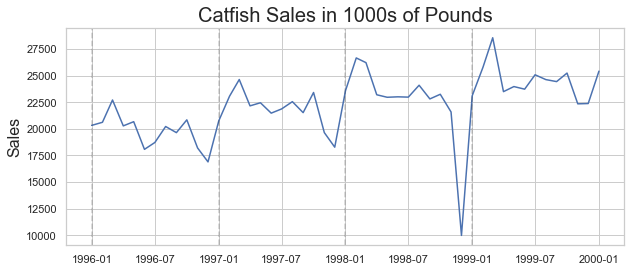

In [71]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Seasonal Decompose

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

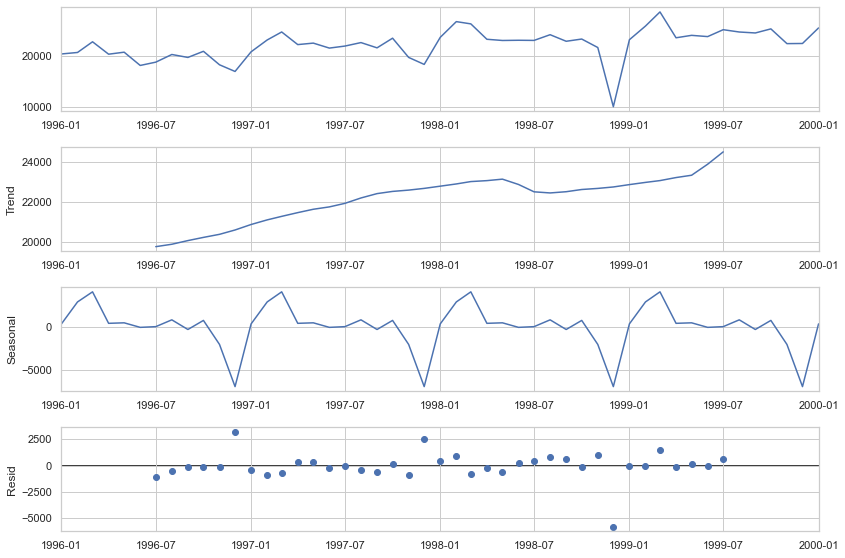

In [73]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(lim_catfish_sales,model='additive')
fig = result.plot()

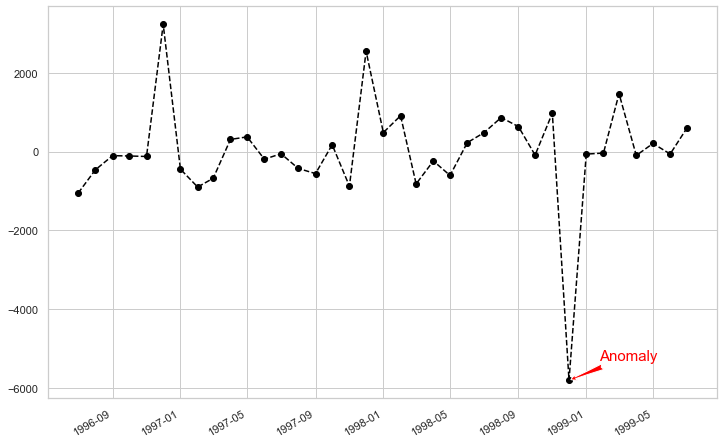

In [74]:
#plt.rc('figure',figsize=(12,6))
#plt.rc('font',size=15)

fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color='black',linestyle='--')

ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20), 
           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))

fig.autofmt_xdate()
plt.show()

### Introduce some more point outliers

In [75]:
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

## Isolation forest

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

<AxesSubplot:xlabel='Date'>

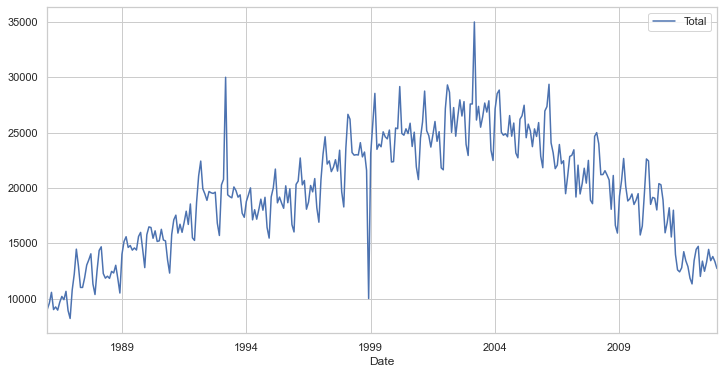

In [77]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
catfish_sales.plot()

In [78]:
outliers_fraction = float(.01)

In [79]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [80]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.01)

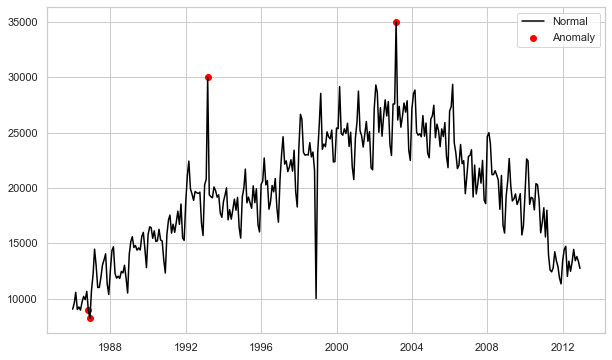

In [81]:
catfish_sales['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Kmeans

In [82]:
from sklearn.cluster import KMeans

In [83]:
df = pd.read_csv('data/TimeSeriesExpedia.csv')

In [84]:
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,63,2013-05-23 11:56:25,14,100,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,90,2013-04-23 11:12:24,14,100,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,133,2013-03-14 11:27:28,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,148,2013-03-21 02:24:03,10,4,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,203,2013-01-03 20:48:24,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,1.0,0.0,14.0,0,NaN,0
5,375,2013-01-19 16:51:27,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
6,712,2013-01-26 11:34:23,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
7,751,2013-04-29 09:39:50,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
8,803,2013-03-25 19:43:44,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
9,932,2013-01-02 22:01:57,32,220,4.00,246.15,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


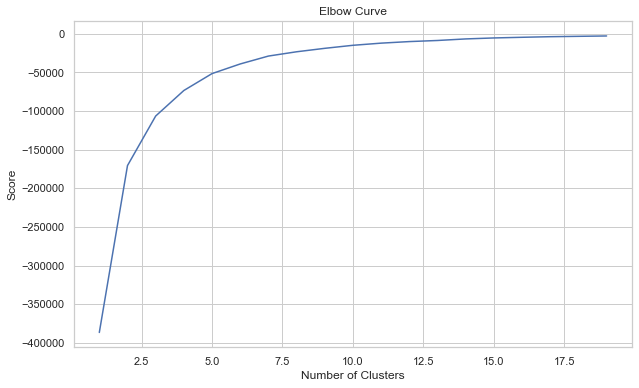

In [85]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

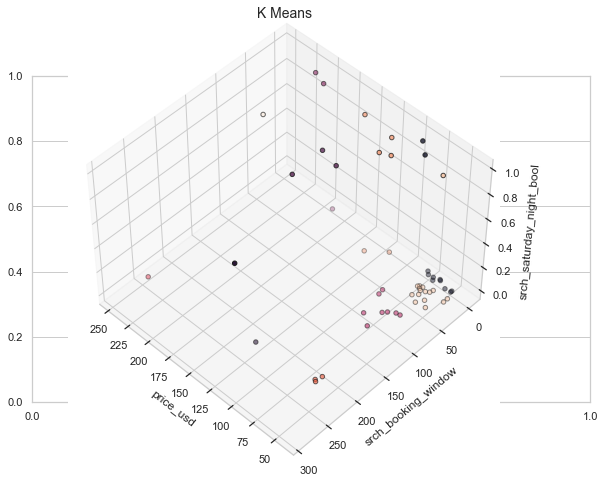

In [86]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
# #Plotting
fig,ax = plt.subplots(figsize=(10,6))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

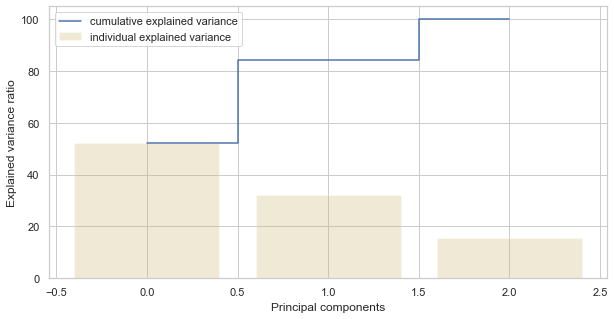

In [87]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'y')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [88]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [89]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

3    13
1    11
8     8
7     7
5     4
9     3
2     3
6     2
4     2
0     1
Name: cluster, dtype: int64

In [90]:
kmeans[9]

KMeans(n_clusters=10)

In [91]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.1
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

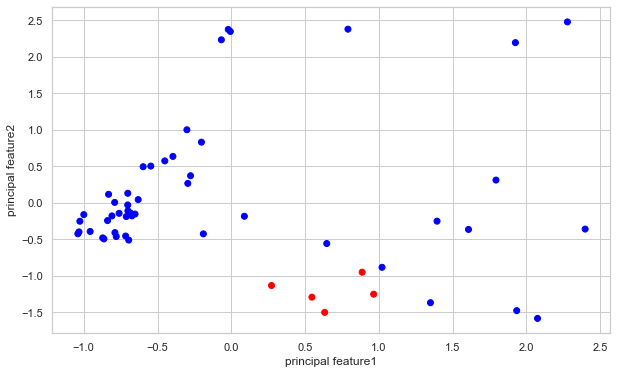

In [92]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

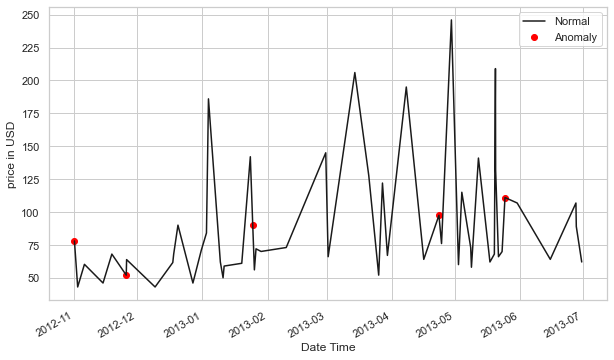

In [93]:
df = df.sort_values('date_time')
#df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly


ax.plot(pd.to_datetime(df['date_time']), df['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()

## Forecasting

In [3]:
from prophet import Prophet

In [4]:
t = pd.DataFrame()
t['ds'] = catfish_sales.index
t['y'] = catfish_sales['Total'].values

NameError: name 'pd' is not defined

In [104]:
t

,ds,y
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239
...,...,...
319,2012-08-01,14442
320,2012-09-01,13422
321,2012-10-01,13795
322,2012-11-01,13352


In [105]:
import altair as alt
#alt.renderers.enable('notebook')

In [106]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(t)

Initial log joint probability = -15.2405
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       697.457    0.00195447       191.233   1.882e-05       0.001      160  LS failed, Hessian reset 
      99       698.836     0.0012588       84.3828      0.2852      0.2852      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       699.445   0.000884218       84.4718   1.121e-05       0.001      359  LS failed, Hessian reset 
     199       699.485   0.000215781       52.8067           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       699.636   2.05622e-05       68.2599   3.669e-07       0.001      469  LS failed, Hessian reset 
     299       699.638   6.66519e-06       61.6449           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

In [107]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [108]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

# Autoencoders

In [110]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

2022-07-06 20:41:42.390292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 20:41:42.390312: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [111]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

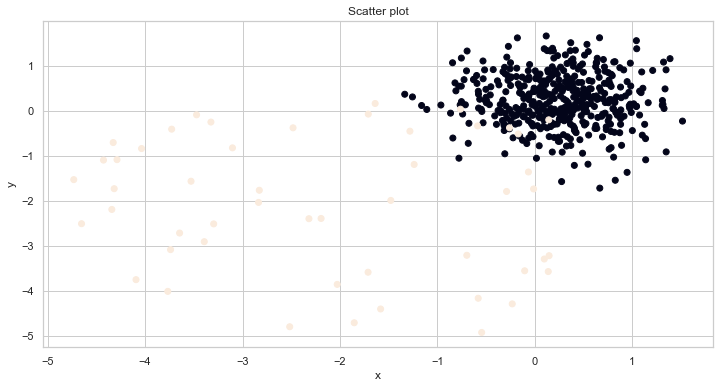

In [112]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
cdict = {0: 'red', 1: 'blue'}
# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=1)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [113]:
clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf.fit(X_train)

2022-07-06 20:42:21.757160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 20:42:21.757186: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 20:42:21.757208: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ti): /proc/driver/nvidia/version does not exist
2022-07-06 20:42:21.757414: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                650       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

2022-07-06 20:42:21.975901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


15/15 [==============================] - 1s 10ms/step - loss: 4.0236 - val_loss: 2.2143
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 3.3350 - val_loss: 2.0176
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 2.9227 - val_loss: 1.8911
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 2.7000 - val_loss: 1.8007
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 2.5382 - val_loss: 1.7248
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 2.4153 - val_loss: 1.6579
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 2.3080 - val_loss: 1.5946
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 2.2012 - val_loss: 1.5315
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 2.1159 - val_loss: 1.4688
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 2.0251 - val_loss: 1.4067
Epoch 11/100
15/15 [

15/15 [==============================] - 0s 2ms/step - loss: 1.1286 - val_loss: 0.7156
Epoch 84/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1311 - val_loss: 0.7144
Epoch 85/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1257 - val_loss: 0.7133
Epoch 86/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1287 - val_loss: 0.7124
Epoch 87/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1300 - val_loss: 0.7116
Epoch 88/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1212 - val_loss: 0.7101
Epoch 89/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1245 - val_loss: 0.7092
Epoch 90/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1256 - val_loss: 0.7086
Epoch 91/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1234 - val_loss: 0.7080
Epoch 92/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1242 - val_loss: 0.7071
Epoch 93/100


AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f287ebcbaf0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

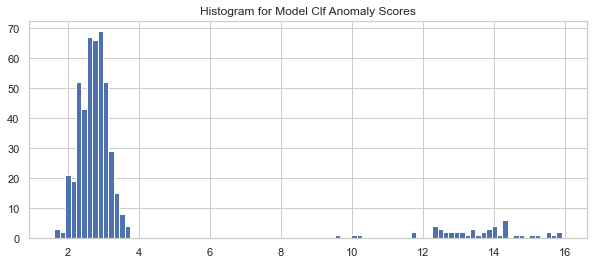

In [114]:
# Get the outlier scores for the train data
y_train_scores = clf.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf Anomaly Scores")
plt.show()

In [115]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

t = df_test.groupby('cluster').mean()

In [116]:
pd.set_option('display.max_rows', 500)
t.T

cluster,0,1
0,0.248812,-2.239305
1,0.235591,-2.120321
2,0.254013,-2.286113
3,0.239429,-2.154863
4,0.239101,-2.151912
5,0.255499,-2.299489
6,0.257207,-2.314860
7,0.244380,-2.199420
8,0.248004,-2.232040
9,0.251948,-2.267535


# What to do about the anomaly?

## Simple Idea: use mean of other months

In [ ]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()dd
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [117]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

NameError: name 'december_data' is not defined

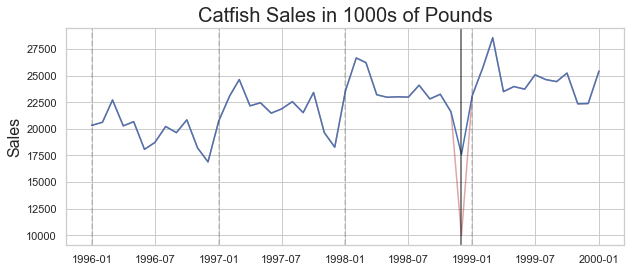

In [30]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# Resulting Predictions

In [118]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

TypeError: 'module' object is not callable

In [119]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

NameError: name 'test_data' is not defined

In [120]:
rolling_residuals = test_data - rolling_predictions

NameError: name 'test_data' is not defined

In [121]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

NameError: name 'rolling_residuals' is not defined

<Figure size 720x288 with 0 Axes>

NameError: name 'rolling_predictions' is not defined

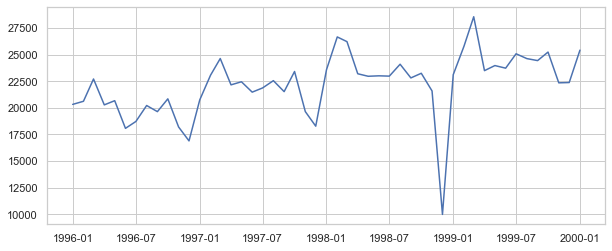

In [122]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

In [123]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

NameError: name 'rolling_residuals' is not defined